# Outbreaks

Exploratory stuff to figure out how best to define "outbreak"


In [1]:
# init

from matplotlib import pyplot
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import seaborn as sns

from covid19stats.common import *

conn = get_db_conn()

sns.set(style="darkgrid")

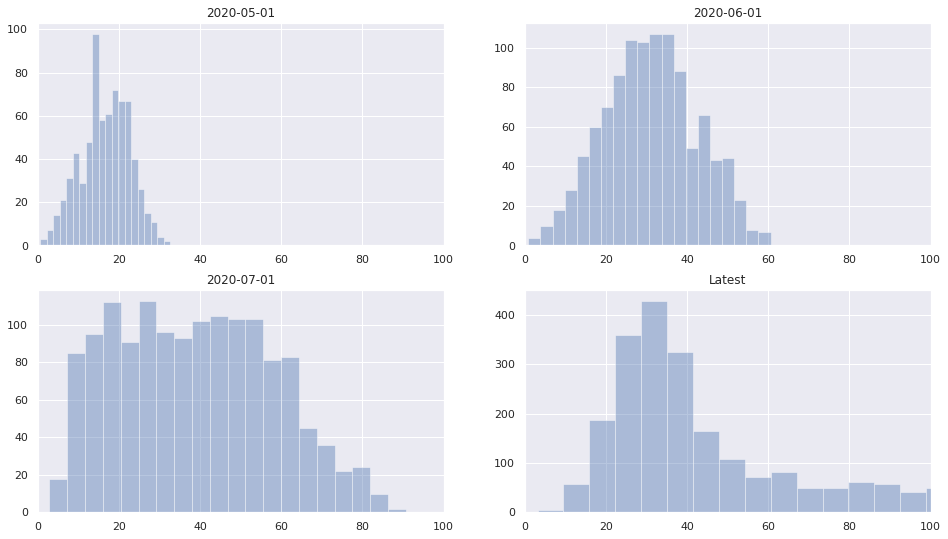

In [2]:
# Experiment with doubling times

sql = """
select
    DoublingTimeDays
from fact_counties_progress
WHERE 
    date = '2020-05-01'
    and Confirmed >= 100;
"""

df_may = psql.read_sql(sql, conn)

sql = """
select
    DoublingTimeDays
from fact_counties_progress
WHERE 
    date = '2020-06-01'
    and Confirmed >= 100;
"""

df_jun = psql.read_sql(sql, conn)

sql = """
select
    DoublingTimeDays
from fact_counties_progress
WHERE 
    date = '2020-07-01'
    and Confirmed >= 100;
"""

df_jul = psql.read_sql(sql, conn)

sql = """
select
    DoublingTimeDays
from fact_counties_progress
WHERE
    date = (select max(date) from fact_counties_progress)
    and Confirmed >= 100;
"""

df_latest = psql.read_sql(sql, conn)

fig, ax = pyplot.subplots(2, 2, figsize=[16, 9])

s = sns.distplot(df_may, bins=20, ax=ax[0][0], kde=False)
s.set_title('2020-05-01')
s.set(xlim=(0,100))

s = sns.distplot(df_jun, bins=20, ax=ax[0][1], kde=False)
s.set_title('2020-06-01')
s.set(xlim=(0,100))

s = sns.distplot(df_jul, bins=20, ax=ax[1][0], kde=False)
s.set_title('2020-07-01')
s.set(xlim=(0,100))

s = sns.distplot(df_latest, bins=20, ax=ax[1][1], kde=False)
s.set_title('Latest')
s.set(xlim=(0,100));

In [3]:
# What's the distribution of Confirmed cases?

sql = """
select
    CASE
        WHEN Confirmed IS NULL OR Confirmed = 0 THEN 0
        WHEN Confirmed <= 100 THEN 100
        WHEN Confirmed <= 200 THEN 200
        WHEN Confirmed <= 300 THEN 300
        WHEN Confirmed <= 400 THEN 400
        WHEN Confirmed <= 500 THEN 500
        WHEN Confirmed <= 600 THEN 600
        WHEN Confirmed <= 700 THEN 700
        WHEN Confirmed <= 800 THEN 800
        WHEN Confirmed <= 900 THEN 900
        WHEN Confirmed <= 1000 THEN 1000
        WHEN Confirmed <= 5000 THEN 5000
        WHEN Confirmed <= 10000 THEN 10000
        ELSE 100000
    END
    AS UpperLimit
    ,Confirmed
    ,1 as Testo
from fact_counties_progress
WHERE 
    Date = (select max(Date) from fact_counties_progress)
    and TwoWeekAvg7DayConfirmedIncreasePct > 1.0
"""

df = psql.read_sql(sql, conn)

# show counts using our custom field, to sanity check the distplot
df.groupby('UpperLimit').UpperLimit.value_counts()

UpperLimit  UpperLimit
100         100           166
200         200           101
300         300            39
400         400            17
500         500            12
600         600            17
700         700             5
800         800             4
900         900             2
1000        1000            3
5000        5000           18
10000       10000           2
100000      100000          6
Name: UpperLimit, dtype: int64

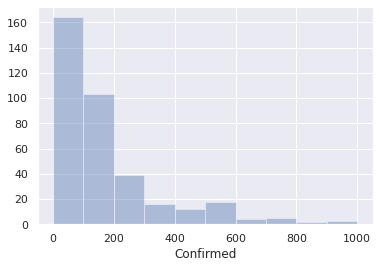

In [4]:
# this should match counts above

s = sns.distplot(
    df['Confirmed'],\
    bins=[0, 100,200,300,400,500,600,700,800,900,1000],\
    kde=False)

In [5]:
# WA State uses measure of less than 25 cases per 100,000 in a two week period
# to determine readiness for reopening

sql = """
with t as (
    select 
        State
        ,SUM(CASE WHEN CasesPer100k < 25 THEN 1 ELSE 0 END) as LessThan25
        ,COUNT(*) as NumCounties
    from fact_counties_progress a 
    join dim_county dc 
        on a.fips = dc.fips
        and a.date = (select max(Date) from fact_counties_progress)
    group by state
)
select
    *
    ,cast(LessThan25 as real) / NumCounties as CountiesPct
from t;
"""

df = psql.read_sql(sql, conn)

df

,State,LessThan25,NumCounties,CountiesPct
0,Alabama,0,67,0.000000
1,Alaska,6,26,0.230769
2,Arizona,1,15,0.066667
3,Arkansas,0,75,0.000000
4,California,3,58,0.051724
5,Colorado,11,63,0.174603
6,Connecticut,3,8,0.375000
7,Delaware,0,3,0.000000
8,Diamond Princess,1,1,1.000000
9,District of Columbia,0,1,0.000000


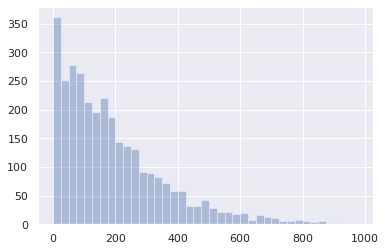

In [6]:
# What's the distribution of CasesPer100k measure?

sql = """
    select 
        CasesPer100k
    from fact_counties_progress a 
    join dim_county dc 
        on a.fips = dc.fips
        and a.date = (select max(Date) from fact_counties_progress)
"""

df = psql.read_sql(sql, conn)

s = sns.distplot(
    df,\
    bins=range(0,1000,25),\
    kde=False)

In [7]:
#print(df.quantile(0.2, interpolation='nearest'))

#print(df.median())

pd.cut(df['CasesPer100k'], 5, retbins=True)[1]

#df[df['CasesPer100k'] < 0]

#

array([  -10.88815008,  2177.63001662,  4355.26003325,  6532.89004987,
        8710.52006649, 10888.15008312])